In [1]:
import gammapy
gammapy.__version__

'0.20.dev114+gf3b29861d'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import astropy.units as u
import warnings
from copy import deepcopy
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from pathlib import Path
import numpy as np
from regions import CircleSkyRegion
# from gammapy.utils.regions import make_region
from scipy.stats import norm,chi2
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    MapDataset,
)
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    ReflectedRegionsBackgroundMaker,
    FoVBackgroundMaker,
    HessMapDatasetMaker
)
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.estimators import ExcessMapEstimator, LightCurveEstimator

In [4]:
# Configure the logger, so that the 3D analysis isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("Crab-analysis")
log.setLevel(logging.INFO)
# See https://docs.python.org/3/library/logging.html#levels to get the different level of print-out
#log.setLevel(logging.ERROR)

In [5]:
BASE_DIR = "$CALDB/he_stereo_Prod17_Calib0834_thsq64"
SRC_POS = SkyCoord.from_name('Crab')
print(SRC_POS)
SELECTION_RADIUS = 1.2 * u.deg 
GEOM_WIDTH = 6 * u.deg
# OFFSET_MAX_CUTOUTS = 10 * u.deg
OFFSET_MAX_SAFE = 2 * u.deg
GEOM_BINSZ = 0.02 * u.deg
E_MIN = 0.5 * u.TeV
E_MAX = 150 * u.TeV
E_NBINS = 20
E_TRUE_MIN = 0.1 * u.TeV
E_TRUE_MAX = 200 * u.TeV
E_TRUE_NBINS = 50

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>


In [6]:
data_store = DataStore.from_dir(BASE_DIR)
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/khelifi/HESS/data/hap-16-03_fitscl7/Prod17_Calib0834/he_stereo_Prod17_Calib0834_thsq64
Rows: 125922
OBS_ID: 18092 -- 154591
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 21119



In [7]:
# Select observations
warnings.filterwarnings("ignore")
selection = dict(type='sky_circle', frame='galactic',
                 lon=SRC_POS.galactic.l,
                 lat=SRC_POS.galactic.b,
                 radius=SELECTION_RADIUS,
                 border=Angle(0.4, 'deg'))
selected_obs_table = data_store.obs_table.select_observations(selection)
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

In [8]:
len(observations)

343

In [9]:
# Geometry
# We now fix the energy axis for the counts map - (the reconstructed energy binning)
e_reco = MapAxis.from_energy_bounds(E_MIN,E_MAX, E_NBINS, unit="TeV", name="energy")

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
e_true = MapAxis.from_energy_bounds(E_TRUE_MIN, E_TRUE_MAX, E_TRUE_NBINS, unit="TeV", name="energy_true")

# The WCS geometry - centered on the galactic center
geom = WcsGeom.create(skydir=SRC_POS, width=GEOM_WIDTH, binsz=GEOM_BINSZ, frame="galactic", axes=[e_reco])
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 20)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 184.6 deg, -5.8 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 184.6 deg, -5.8 deg



In [10]:
# Dataset configuration
dataset_empty = MapDataset.create(geom=geom, energy_axis_true=e_true)
stacked = MapDataset.create(geom=geom, energy_axis_true=e_true, name="Crab-stacked-noTC")

# dataset_maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf", "edisp"])
# This is equivalent to ``maker = MapDatasetMaker()''
dataset_maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf", "edisp"])

safe_mask_maker = SafeMaskMaker(methods=["offset-max", "aeff-default","bkg-peak"], offset_max=OFFSET_MAX_SAFE)
# See the documentation of `~gammapy.makers.SafeMaskMaker` to get the full list of options
# This maker is important to handle properly the systematic errors of the instrument

circle = CircleSkyRegion(center=geom.center_skydir, radius=0.4 * u.deg)
exclusion_mask = geom.region_mask([circle], inside=False)

fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask, min_counts=20)
fov_bkg_maker.default_spectral_model.parameters['tilt'].frozen = False

In [11]:
# Filter out problematic runs (i.e. runs that miss something)
stable = False
print("Number of observations before filtering: ", len(observations.ids))

while stable is not True:
    length_before = deepcopy(len(observations.ids))
    for obs in observations:
        try:
            obs.aeff
        except:
            idx = list(observations).index(obs)
            print("No aeff - Removing run ", observations.ids[idx])
            observations.pop(index=idx)
        try:
            obs.bkg
        except:
            idx = list(observations).index(obs)
            print("No bkg - Removing run ", observations.ids[idx])
            observations.pop(index=idx)
    length_after = deepcopy(len(observations.ids))        
    if length_after == length_before:
        stable = True
        
print("Number of observations after filtering: ", len(observations.ids))

Number of observations before filtering:  343
Number of observations after filtering:  343


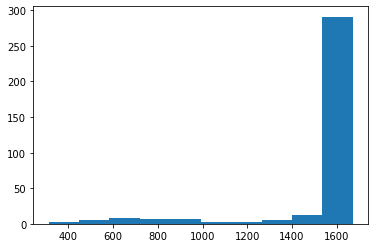

In [12]:
livetimes = []
for obs in observations:
    livetimes.append(obs.obs_info["LIVETIME"].value)
plt.hist(livetimes);

In [13]:
# Filter out low quality runs
stable = False
print("Number of observations before filtering: ", len(observations.ids))

while stable is not True:
    length_before = deepcopy(len(observations.ids))
    for obs in observations:
        quality = obs.obs_info["QUALITY"]
        if quality >= 1:
            idx = list(observations).index(obs)
            print(f"Bad quality ({quality}): ", observations.ids[idx])
            observations.pop(index=idx)
            continue
        livetime = obs.obs_info["LIVETIME"].value
        if livetime < 600:
            idx = list(observations).index(obs)
            print(f"Too short run ({livetime/60:.1f}min): ", observations.ids[idx])
            observations.pop(index=idx)
            continue
    length_after = deepcopy(len(observations.ids))        
    if length_after == length_before:
        stable = True
        
print("Number of observations after filtering: ", len(observations.ids))

Number of observations before filtering:  343
Too short run (9.3min):  18517
Too short run (9.6min):  135129
Too short run (9.9min):  145086
Too short run (9.3min):  90352
Too short run (9.3min):  90382
Too short run (6.8min):  145956
Too short run (8.9min):  127958
Too short run (5.2min):  144012
Number of observations after filtering:  335


In [14]:
# energy_thresholds = []

# for obs in observations:
#     sep = SRC_POS.separation(obs.pointing_radec)
# #     aeff1D = obs.aeff.to_effective_area_table(offset=sep)
#     aeff1D = obs.aeff.evaluate(offset=sep)
#     aeff_max = np.max(aeff1D)
#     print(aeff_max)
#     energy_threshold = aeff1D.find_energy(0.1 * aeff_max)
#     energy_thresholds.append(energy_threshold.value) # in TeV

In [15]:
# plt.hist(np.asarray(energy_thresholds) * 1.0e3, bins=80);
# plt.xlabel('GeV');
# plt.xlim(200,2000)
# plt.title('E_safe histogram')
# #plt.savefig('esafe.png')

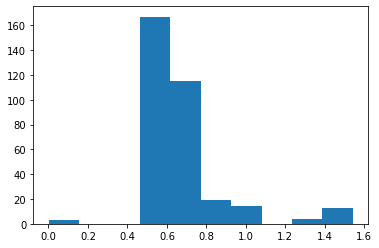

In [16]:
offsets = []
for obs in observations:
    offset = SRC_POS.separation(obs.pointing_radec)
    offsets.append(offset.value)
offsets = np.array(offsets)
plt.hist(offsets);

In [17]:
bin1 = offsets < 1.
bin2 = offsets > 1.

In [18]:
# We separate hess1 and hess1u runs, to be consistent with hap-hd 
obs_ids = []
first_hess1u_id = 127821
for obs in observations:
    obs_ids.append(obs.obs_id)
obs_ids = np.array(obs_ids)
hess1 = obs_ids < first_hess1u_id
hess1u = obs_ids >= first_hess1u_id

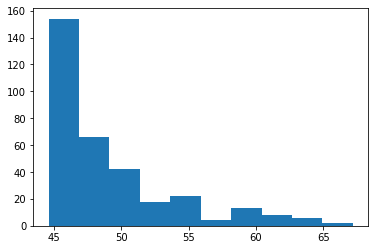

In [19]:
zeniths = []
for obs in observations:
    zenith = obs.pointing_zen
    zeniths.append(zenith.value)
zeniths = np.array(zeniths)
plt.hist(zeniths);

In [20]:
bina = zeniths < 50
binb = zeniths > 50

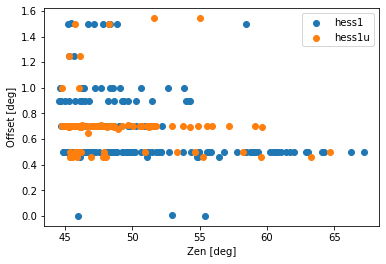

In [21]:
plt.scatter(zeniths[hess1], offsets[hess1], label="hess1")
plt.scatter(zeniths[hess1u], offsets[hess1u], label="hess1u")
plt.xlabel("Zen [deg]")
plt.ylabel("Offset [deg]")
plt.legend();

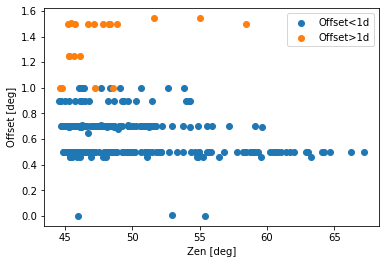

In [22]:
plt.scatter(zeniths[bin1], offsets[bin1], label="Offset<1d")
plt.scatter(zeniths[bin2], offsets[bin2], label="Offset>1d")
plt.xlabel("Zen [deg]")
plt.ylabel("Offset [deg]")
plt.legend();

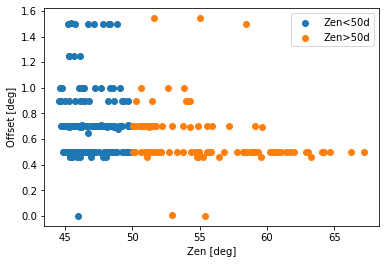

In [23]:
plt.scatter(zeniths[bina], offsets[bina], label="Zen<50d")
plt.scatter(zeniths[binb], offsets[binb], label="Zen>50d")
plt.xlabel("Zen [deg]")
plt.ylabel("Offset [deg]")
plt.legend();

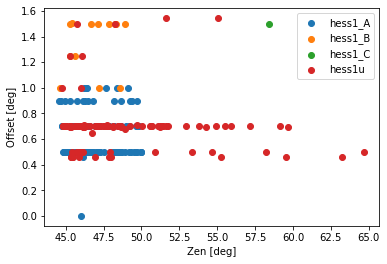

In [24]:
plt.scatter(zeniths[hess1&bina&bin1], offsets[hess1&bina&bin1], label="hess1_A")
plt.scatter(zeniths[hess1&bina&bin2], offsets[hess1&bina&bin2], label="hess1_B")
plt.scatter(zeniths[hess1&binb&bin2], offsets[hess1&binb&bin2], label="hess1_C")
plt.scatter(zeniths[hess1u], offsets[hess1u], label="hess1u")
plt.xlabel("Zen [deg]")
plt.ylabel("Offset [deg]")

plt.legend();

In [25]:
hess1_A = obs_ids[hess1&bina&bin1]
hess1_B = obs_ids[hess1&bina&bin2]
hess1_C = obs_ids[hess1&binb&bin2]
hess1U = obs_ids[hess1u]

obs_bins = {
    "hess1_A" : list(hess1_A),
    "hess1_B" : list(hess1_B),
    "hess1_C" : list(hess1_C),
    "hess1u" : list(hess1U),
}

## Make the data reduction

In [26]:
%%time
warnings.filterwarnings("ignore")
datasets = Datasets() # It will contain a list of MapDatasets

for obs in observations:
#     obs_TC = obs.obs_info["TC"]
    dataset = dataset_maker.run(dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs)
    
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = fov_bkg_maker.run(dataset)
    rel_err = dataset.background_model.spectral_model.norm.error/dataset.background_model.spectral_model.norm.value
    if rel_err > 0.15:
        print(f"TOO big bkg norm error for obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
         +/- {dataset.background_model.spectral_model.norm.error:.2f}")
        continue
    stacked.stack(dataset)
    datasets.append(dataset)
    # print(f"{obs.obs_id}: {rel_err:.2f}")
    # if obs.obs_id>18478:
    if obs.obs_id>125000:
        break
print(f"Number of retained observations: {len(datasets)}\n")

Number of retained observations: 150

CPU times: user 18min 47s, sys: 7min 11s, total: 25min 59s
Wall time: 26min 20s


In [27]:
print(stacked)

MapDataset
----------

  Name                            : Crab-stacked-noTC 

  Total counts                    : 169030 
  Total background counts         : 152872.45
  Total excess counts             : 16157.55

  Predicted counts                : 152872.43
  Predicted background counts     : 152872.45
  Predicted excess counts         : nan

  Exposure min                    : 5.72e-02 m2 s
  Exposure max                    : 2.30e+11 m2 s

  Number of total bins            : 1800000 
  Number of fit bins              : 1244518 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




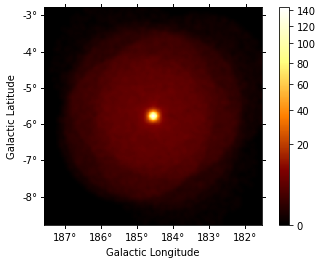

In [28]:
stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(stretch="sqrt", add_cbar=True);

In [29]:
path = Path("Crab_TC")
path.mkdir(exist_ok=True)

filename = path / "crab-noTC-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)
filename = path / "crab-noTC-datasets.fits.gz"
datasets.write(filename, overwrite=True)

## Read the reduced data

In [30]:
# path = Path("/home/khelifi/MesProgrammes/pyperso/scripts/Crab/Crab_TC")
# filename = path / "crab-noTC-stacked-dataset.fits.gz"
# # print(filename)
# stacked = MapDataset.read(filename)
# filename = path / "crab-noTC-datasets.fits.gz"
# datasets = Datasets.read(filename)

In [31]:
# print(stacked)

## Make the fit

In [32]:
# spatial_model = PointSpatialModel(lon_0=SRC_POS.ra, lat_0=SRC_POS.dec, frame="icrs")
spatial_model = GaussianSpatialModel(lon_0=SRC_POS.ra, lat_0=SRC_POS.dec, frame="icrs",
                                     sigma="0.03 deg", e=0., phi=Angle("0 deg"))

expo = True
if not expo:
    spectral_model = PowerLawSpectralModel(
        index=2.702,
        amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
        reference=1 * u.TeV,
    )
else:
    spectral_model = ExpCutoffPowerLawSpectralModel(
        index=2.4,
        amplitude=4.0e-11 * u.Unit("1 / (cm2 s TeV)"),
        lambda_=1./(10*u.TeV),
        reference=1 * u.TeV,
    )
    
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

In [33]:
emin_fit = 2.
emax_fit = 40.
coords = stacked.counts.geom.get_coord()
mask_energy = np.logical_and(coords["energy"] < emax_fit * u.TeV, coords["energy"] >= emin_fit * u.TeV)
stacked.mask_fit = Map.from_geom(geom=stacked.counts.geom, data=mask_energy)

In [34]:
stacked.models = [sky_model, bkg_model]
print(stacked)

MapDataset
----------

  Name                            : Crab-stacked-noTC 

  Total counts                    : 169030 
  Total background counts         : 152872.45
  Total excess counts             : 16157.55

  Predicted counts                : 168651.08
  Predicted background counts     : 152872.43
  Predicted excess counts         : 15778.65

  Exposure min                    : 5.72e-02 m2 s
  Exposure max                    : 2.30e+11 m2 s

  Number of total bins            : 1800000 
  Number of fit bins              : 732210 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 380828.27

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
 

In [35]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

    (83.63308333, 18.98074152)> is outside valid IRF map range, using nearest IRF defined within
    (83.63308333, 18.98074152)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 57.7 s, sys: 10.5 s, total: 1min 8s
Wall time: 1min 9s


In [36]:
print(stacked)

MapDataset
----------

  Name                            : Crab-stacked-noTC 

  Total counts                    : 169030 
  Total background counts         : 152872.45
  Total excess counts             : 16157.55

  Predicted counts                : 165816.15
  Predicted background counts     : 150672.32
  Predicted excess counts         : 15143.83

  Exposure min                    : 5.72e-02 m2 s
  Exposure max                    : 2.30e+11 m2 s

  Number of total bins            : 1800000 
  Number of fit bins              : 732210 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 378245.17

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
 

In [37]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 342
	total stat : 378245.17

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [38]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str21,str8,str9,float64,str14,float64,float64,float64,bool,str1
crab,spectral,index,1.7978e+00,,4.311e-02,nan,nan,False,
crab,spectral,amplitude,1.7716e-11,cm-2 s-1 TeV-1,6.897e-13,nan,nan,False,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
crab,spectral,lambda_,5.6611e-02,TeV-1,5.794e-03,nan,nan,False,
crab,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
crab,spatial,lon_0,8.3630e+01,deg,7.416e-04,nan,nan,False,
crab,spatial,lat_0,2.2022e+01,deg,6.899e-04,-9.000e+01,9.000e+01,False,
crab,spatial,sigma,1.8861e-02,deg,9.267e-04,0.000e+00,nan,False,
crab,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,


In [39]:
crab_exp = ExpCutoffPowerLawSpectralModel(
    index=2.37,
    amplitude=3.76e-11 * u.Unit("1 / (cm2 s TeV)"),
    lambda_=1./(11.2*u.TeV),
    reference=1 * u.TeV,
)
crab_exp.parameters["index"].error = 0.03
crab_exp.parameters["amplitude"].error = 0.07e-11* u.Unit("1 / (cm2 s TeV)")
crab_exp.parameters["lambda_"].error = 2.1*(crab_exp.parameters["lambda_"].value)**2* u.Unit("1 / (TeV)")

crab_pl = PowerLawSpectralModel(
    index=2.63,
    amplitude=3.45e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
crab_pl.parameters["index"].error = 0.01
crab_pl.parameters["amplitude"].error = 0.05e-11* u.Unit("1 / (cm2 s TeV)")

In [40]:
if expo:
    print(1/result.parameters['lambda_'].value*u.TeV)
    print("2006 papers:")
    print(crab_exp)
else:
    print("2006 papers:")
    print(crab_pl)
    print("MdN:") #https://hess-confluence.desy.de/confluence/display/~mzacharias/Crab+Test+September+2020?preview=/201162960/201392308/Crab_Nebula_ModelPlus_HESSI_Stereo_Std_Spectrum_SpectrumPowerLaw.png
    print("index: 2.62 +/- 0.03")
    print("amplitude: 3.73e-11 +/- 1.25e-12 cm-2 s-1 TeV-1") 

17.664363887817796 TeV
2006 papers:
ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral     index 2.3700e+00                3.000e-02 nan nan  False     
spectral amplitude 3.7600e-11 cm-2 s-1 TeV-1 7.000e-13 nan nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True     
spectral   lambda_ 8.9286e-02          TeV-1 1.674e-02 nan nan  False     
spectral     alpha 1.0000e+00                0.000e+00 nan nan   True     


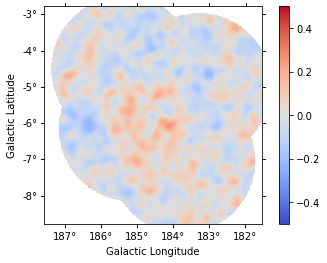

In [41]:
stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5);

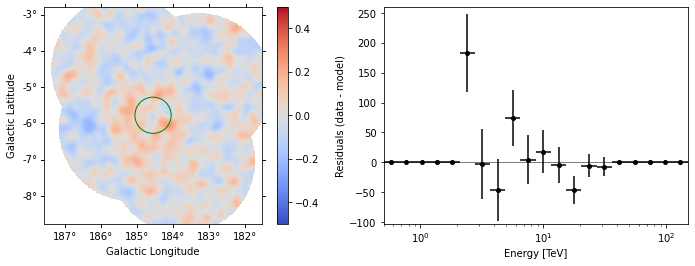

In [42]:
region = CircleSkyRegion(
    center=SkyCoord(SRC_POS.ra, SRC_POS.dec), radius=0.5 * u.deg
)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

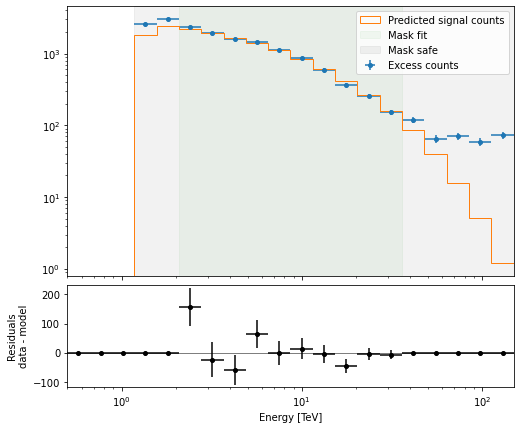

In [43]:
sp_stacked = stacked.to_spectrum_dataset(on_region=region)
sp_stacked.models = sky_model
ax_spectrum, ax_residuals = sp_stacked.plot_fit()
# ax_spectrum.set_ylim(10, 12000)
sp_stacked.plot_masks(ax=ax_spectrum);

spec = sky_model.spectral_model

In [44]:
energy_bounds = [emin_fit, emax_fit] * u.TeV
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
#     energy_bounds = [0.3, 10] * u.TeV
    ax = spec.plot(
        energy_bounds=energy_bounds, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_bounds=energy_bounds, energy_power=2, color=color)
    return ax

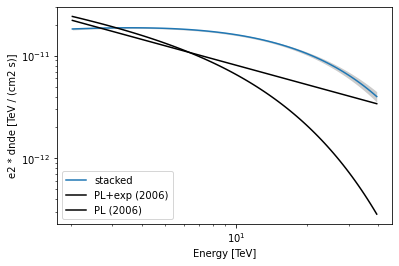

In [45]:
ax = plot_spectrum(sky_model, result, label="stacked", color="tab:blue")
# plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
crab_exp.plot(ax=ax, energy_bounds=energy_bounds, energy_power=2, color='black', label='PL+exp (2006)')
crab_pl.plot(ax=ax, energy_bounds=energy_bounds, energy_power=2, color='black', label='PL (2006)')
plt.legend();

## Light Curve

In [46]:
%%time
time_intervals = [
    Time(['2004-01-01 00:00:00','2004-12-31 00:00:00'], scale="utc"),
    Time(['2005-01-01 00:00:00','2005-12-31 00:00:00'], scale="utc"),
    Time(['2006-01-01 00:00:00','2006-12-31 00:00:00'], scale="utc"),
    Time(['2007-01-01 00:00:00','2007-12-31 00:00:00'], scale="utc"),
    Time(['2008-01-01 00:00:00','2008-12-31 00:00:00'], scale="utc"),
    Time(['2009-01-01 00:00:00','2009-12-31 00:00:00'], scale="utc"),
    Time(['2010-01-01 00:00:00','2010-12-31 00:00:00'], scale="utc"),
    Time(['2011-01-01 00:00:00','2011-12-31 00:00:00'], scale="utc"),
    Time(['2012-01-01 00:00:00','2012-12-31 00:00:00'], scale="utc"),
    Time(['2013-01-01 00:00:00','2013-12-31 00:00:00'], scale="utc"),
    Time(['2014-01-01 00:00:00','2014-12-31 00:00:00'], scale="utc"),
    Time(['2015-01-01 00:00:00','2015-12-31 00:00:00'], scale="utc"),
    Time(['2016-01-01 00:00:00','2016-12-31 00:00:00'], scale="utc"),
    Time(['2017-01-01 00:00:00','2017-12-31 00:00:00'], scale="utc"),
    Time(['2018-01-01 00:00:00','2018-12-31 00:00:00'], scale="utc"),
    Time(['2019-01-01 00:00:00','2019-12-31 00:00:00'], scale="utc"),
]

lc_maker_3d = LightCurveEstimator(
    energy_edges=[emin_fit, emax_fit] * u.TeV, time_intervals=time_intervals,
    source="crab", reoptimize=False, selection_optional="all",
)

for ds in datasets:
    ds_model = ds.models[0]
    ds.models = [ds_model, sky_model]

CPU times: user 86.7 ms, sys: 4.95 ms, total: 91.7 ms
Wall time: 82.8 ms


In [47]:
%%time
lc_3d = lc_maker_3d.run(datasets)

CPU times: user 17min 2s, sys: 2min 15s, total: 19min 18s
Wall time: 19min 53s


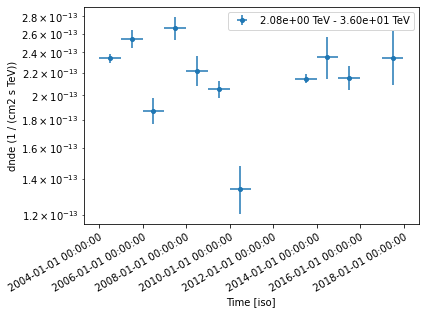

In [48]:
lc_3d.plot(axis_name="time");

In [49]:
# lc_3d.plot(color="tab:orange")
# ax = lc_3d.plot_ts_profiles()
# ax.set_ylim(1e-12, 3e-12);

In [50]:
table = lc_3d.to_table(format="lightcurve", sed_type="flux")
table["time_min", "time_max", "e_min", "e_max", "flux", "flux_err"]

time_min,time_max,e_min [1],e_max [1],flux [1],flux_err [1]
,,TeV,TeV,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64
53005.00074287037,53370.00074287037,2.0808957251439084,36.04217121202131,8.20167417895583e-12,1.6057020170725732e-13
53371.00074287037,53735.00074287037,2.0808957251439084,36.04217121202131,8.911390518838595e-12,3.4756508864593347e-13
53736.00075444444,54100.00075444444,2.0808957251439084,36.04217121202131,6.549802690101256e-12,3.5278754231869744e-13
54101.00075444444,54465.00075444444,2.0808957251439084,36.04217121202131,9.316577892459255e-12,4.716047141913296e-13
54466.00075444444,54831.00075444444,2.0808957251439084,36.04217121202131,7.76921975833788e-12,4.842615096312361e-13
54832.000766018515,55196.000766018515,2.0808957251439084,36.04217121202131,7.186487427512978e-12,2.5509283156401323e-13
55197.000766018515,55561.000766018515,2.0808957251439084,36.04217121202131,4.686763526905655e-12,4.850067939387882e-13
56293.00077759259,56657.00077759259,2.0808957251439084,36.04217121202131,7.509459961718755e-12,1.476815489535813e-13


In [51]:
# filename = path / "crab-noTC-datasets.fits.gz"
# datasets.write(filename, overwrite=True)